In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Clone the PyTorch I3D model**
https://github.com/piergiaj/pytorch-i3d.git

In [3]:
%cd drive/My Drive/Colab Notebooks/ece285-finalproject/pytorch-i3d
!ls
#! git clone https://github.com/piergiaj/pytorch-i3d.git

/content/drive/.shortcut-targets-by-id/1tV49vvGIvRqIxOAm8HBNDkZ3_2KYtJTs/ece285-finalproject/pytorch-i3d
000010.pt  000510.pt  001010.pt  001510.pt  002010.pt
000020.pt  000520.pt  001020.pt  001520.pt  002020.pt
000030.pt  000530.pt  001030.pt  001530.pt  002030.pt
000040.pt  000540.pt  001040.pt  001540.pt  002040.pt
000050.pt  000550.pt  001050.pt  001550.pt  002050.pt
000060.pt  000560.pt  001060.pt  001560.pt  002060.pt
000070.pt  000570.pt  001070.pt  001570.pt  002070.pt
000080.pt  000580.pt  001080.pt  001580.pt  002080.pt
000090.pt  000590.pt  001090.pt  001590.pt  002090.pt
000100.pt  000600.pt  001100.pt  001600.pt  002100.pt
000110.pt  000610.pt  001110.pt  001610.pt  002110.pt
000120.pt  000620.pt  001120.pt  001620.pt  002120.pt
000130.pt  000630.pt  001130.pt  001630.pt  002130.pt
000140.pt  000640.pt  001140.pt  001640.pt  002140.pt
000150.pt  000650.pt  001150.pt  001650.pt  002150.pt
000160.pt  000660.pt  001160.pt  001660.pt  002160.pt
000170.pt  000670.pt  001170.pt

In [4]:
# Switch to ece285-final project directory
path = "/drive/My Drive/Colab\ Notebooks/ece285-finalproject/pytorch-i3d/"

000010.pt  000510.pt  001010.pt  001510.pt  002010.pt
000020.pt  000520.pt  001020.pt  001520.pt  002020.pt
000030.pt  000530.pt  001030.pt  001530.pt  002030.pt
000040.pt  000540.pt  001040.pt  001540.pt  002040.pt
000050.pt  000550.pt  001050.pt  001550.pt  002050.pt
000060.pt  000560.pt  001060.pt  001560.pt  002060.pt
000070.pt  000570.pt  001070.pt  001570.pt  002070.pt
000080.pt  000580.pt  001080.pt  001580.pt  002080.pt
000090.pt  000590.pt  001090.pt  001590.pt  002090.pt
000100.pt  000600.pt  001100.pt  001600.pt  002100.pt
000110.pt  000610.pt  001110.pt  001610.pt  002110.pt
000120.pt  000620.pt  001120.pt  001620.pt  002120.pt
000130.pt  000630.pt  001130.pt  001630.pt  002130.pt
000140.pt  000640.pt  001140.pt  001640.pt  002140.pt
000150.pt  000650.pt  001150.pt  001650.pt  002150.pt
000160.pt  000660.pt  001160.pt  001660.pt  002160.pt
000170.pt  000670.pt  001170.pt  001670.pt  002170.pt
000180.pt  000680.pt  001180.pt  001680.pt  002180.pt
000190.pt  000690.pt  001190

# **Test Functionality of PyTorch I3D model**

### Starting with charades_dataset.py:


In [0]:
import torch
import torch.utils.data as data_utl
from torch.utils.data.dataloader import default_collate

import numpy as np
import json
import csv
import h5py
import random
import os
import os.path

import cv2

In [0]:
# Testing getting a tensor from one of our .npy files:
def video_to_tensor(pic):
    """Convert a ``numpy.ndarray`` to tensor.
    Converts a numpy.ndarray (T x H x W x C)
    to a torch.FloatTensor of shape (C x T x H x W)
    
    Args:
         pic (numpy.ndarray): Video to be converted to tensor.
    Returns:
         Tensor: Converted video.
    """
    return torch.from_numpy(pic.transpose([3,0,1,2]))



In [7]:
path_to_file = 'data/drive_and_act_dataset/simmons_kinect_ir_train/run2_2018-05-29-16-03-37.kinect_ir.mp4_3266532681.npy'
os.path.exists(path_to_file)

True

In [0]:
test_npy = np.load(path_to_file)

In [9]:
print(test_npy.shape)

# Gray data for now: (FLOW will have 2 channels, RGB will have 3).
num_frames = test_npy.shape[0] / 224
print(num_frames)
re_test_npy = test_npy.reshape(int(num_frames), 224, 224, 1)
print(re_test_npy.shape)

(3136, 224)
14.0
(14, 224, 224, 1)


In [0]:
tensor = video_to_tensor(re_test_npy)


## Adapt make_dataset and charades_dataset to our dataset, Drive&Act:

In [0]:
num_classes = 39

def make_dataset(split_file, split, root, mode, num_classes):
    dataset = []
    with open(split_file, 'r') as f:
        data = json.load(f)

    i = 0
    for vid in data.keys():
        if data[vid]['subset'] != split:
            continue

        if not os.path.exists(os.path.join(root, vid)):
            continue
        num_frames = len(os.listdir(os.path.join(root, vid)))
        if mode == 'flow':
            num_frames = num_frames//2

        # this skips frames too short for the temporal dimension
        if num_frames < 66:
            continue

        label = np.zeros((num_classes,num_frames), np.float32)

        fps = num_frames/data[vid]['duration']
        for ann in data[vid]['actions']:
            for fr in range(0,num_frames,1):
                if fr/fps > ann[1] and fr/fps < ann[2]:
                    label[ann[0], fr] = 1 # binary classification
        dataset.append((vid, label, data[vid]['duration'], num_frames))
        i += 1
    
    return dataset

In [0]:
# Create a path to the training list (created from original .csv for data)
train_list = "data/drive_and_act_dataset/simmons_kinect_ir_train/midlevel.chunks_90.split_0.train.txt"


In [0]:
# Adaptation of make_dataset to use out train_list rather than a .json file: 

# Replace charades_dataset.py with this: 
def make_our_dataset(train_list):
  dataset = []
  with open(train_list, 'r') as f: 
    Lines = f.readlines()
    for line in Lines: 
      contents = line.strip().split(" ")
      vid_path = contents[0]
      activity = contents[1]

      # get number of frames from name of vid_path
      start_str = ".mp4_"
      end_str = ".npy"
      num_frames = (vid_path.split(start_str))[1].split(end_str)[0]

      length = len(num_frames)
      start_frame = int(num_frames[0:int(length/2)])
      end_frame = int(num_frames[int(length/2):length])
      num_frames = end_frame - start_frame

      if int(num_frames) < 66: 
        continue

      dataset.append((vid_path, activity, num_frames))

  return dataset

In [14]:
drive_data = make_our_dataset(train_list)
print(drive_data[0:5])
length = len(drive_data)
print(drive_data[length-5:length])
print(drive_data[0][0])

[('run1b_2018-05-29-14-02-47.kinect_ir.mp4_348439.npy', '9', 91), ('run1b_2018-05-29-14-02-47.kinect_ir.mp4_461531.npy', '10', 70), ('run1b_2018-05-29-14-02-47.kinect_ir.mp4_60216111.npy', '8', 90), ('run1b_2018-05-29-14-02-47.kinect_ir.mp4_61116202.npy', '0', 91), ('run1b_2018-05-29-14-02-47.kinect_ir.mp4_62296311.npy', '10', 82)]
[('run1_2018-05-22-13-28-51.kinect_ir.mp4_5585855950.npy', '33', 92), ('run1_2018-05-22-13-28-51.kinect_ir.mp4_5595056039.npy', '33', 89), ('run1_2018-05-22-13-28-51.kinect_ir.mp4_5603956130.npy', '33', 91), ('run1_2018-05-22-13-28-51.kinect_ir.mp4_5622156311.npy', '9', 90), ('run1_2018-05-22-13-28-51.kinect_ir.mp4_5631156402.npy', '9', 91)]
run1b_2018-05-29-14-02-47.kinect_ir.mp4_348439.npy


In [15]:
print(len(drive_data))

1859


In [10]:
!ls

drive  sample_data


In [0]:
class DriveAndAct(data_utl.Dataset):

    def __init__(self, train_list, mode, root, transforms=None):
        
        self.data = make_our_dataset(train_list)
        self.mode = mode # FLOW, RGB, gray
        self.root = root # root_dir that points to mode .npy files
        self.transforms = transforms # which transforms to perform 

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        vid, label, nf = self.data[index]

        # imgs should be a .npy array with the correct dimensions
        if self.mode == 'rgb':
          # TO DO: change to rgb dir
          print("TO DO: change to rgb dir")
          # gray_path = "data/drive_and_act_dataset/simmons_kinect_ir_train/"
          # imgs = np.load(gray_path + self.data[index][0])
          channels = 3
        elif self.mode == 'flow':
          # TO DO: change to flow dir
          print("TO DO: change to flow dir")
          # gray_path = "data/drive_and_act_dataset/simmons_kinect_ir_train/"
          # imgs = np.load(gray_path + self.data[index][0])
          channels = 2
        elif self.mode == 'gray': 
          gray_path = "data/drive_and_act_dataset/simmons_kinect_ir_train/"
          imgs = np.load(gray_path + self.data[index][0])
          imgs = imgs.astype(np.float32)
          imgs = (imgs/255.)*2-1 # normalization
          channels = 1
        else: 
          print("did not specify correct mode for data")
        
        label = self.data[index][1]

        num_frames = int(imgs.shape[0] / 224)
        imgs = imgs.reshape(int(num_frames), 224, 224, channels)

        num_classes = 39

        # This is for 'gray' mode: (don't need for FLOW or RGB mode)
        imgs = np.repeat(imgs, 3, axis=3)


        label = int(label)
        labels = np.zeros((num_classes,num_frames), np.float32)
        labels[int(label),:] = 1

        return video_to_tensor(imgs), torch.from_numpy(labels)

    def __len__(self):
        return len(self.data)

## **Test functionality of make_our_dataset and DriveAndAct dataset class**


In [0]:
# Switch to simmons_kinect_ir_train/ data for next cell
'''
%cd simmons_kinect_ir_train/
print("after cd")
!ls
'''

'\n%cd simmons_kinect_ir_train/\nprint("after cd")\n!ls\n'

In [0]:
# Create two sample lists: train_list and eval_list: (already done in google drive)
'''
len_ir_dataset = len(drive_data)
print(len_ir_dataset)

original_list = "midlevel.chunks_90.split_0.train.txt"
with open(original_list, 'r') as f1: 
  with open('sample_train_list.txt', 'a') as f2: 
    with open('sample_test_list.txt', 'a') as f3:
      Lines = f1.readlines()
      for i,line in enumerate(Lines):
        if i < int(len_ir_dataset/2):
          f2.write(line) 
        else:
          f3.write(line)

!cat sample_test_list.txt
'''

2405


In [0]:
# Need to be in pytorch-i3d directory

import os

import sys
import argparse




import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms
import videotransforms


import numpy as np

from pytorch_i3d import InceptionI3d

from charades_dataset import DriveAndAct as Dataset


In [18]:
os.path.exists("data/drive_and_act_dataset/simmons_kinect_ir_train/sample_train_list.txt")

True

In [0]:
models/rgb_imagenet.pt
!ls

000010.pt		  LICENSE.txt	  simmons_pytorch_train_i3d.ipynb
charades_dataset_full.py  models	  train_i3d.py
charades_dataset.py	  __pycache__	  videotransforms.py
data			  pytorch_i3d.py
extract_features.py	  README.md


In [0]:
# Need to be in pytorch-i3d directory


# Change batch size equal to 1. 
def drive_run(init_lr=0.1, max_steps=64e3, train_loss = [], val_loss = [], mode='gray', root="data/drive_and_act_dataset/simmons_kinect_ir_train/", batch_size=1, save_model=''):
    
    root_path = "data/drive_and_act_dataset/simmons_kinect_ir_train/"
    train_list = "sample_train_list.txt"
    test_list= "sample_test_list.txt"

    train_transforms = None
    test_transforms = None

    # create a dataset from our DriveAndAct dataset: 
    # !ls
    train_dataset = DriveAndAct(root_path + train_list, mode='gray', root=root_path, transforms=None)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

    val_dataset = DriveAndAct(root_path + test_list, mode='gray', root=root_path, transforms=None)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

    dataloaders = {'train': train_dataloader, 'val': val_dataloader}
    datasets = {'train': train_dataset, 'val': val_dataset}
    
    num_classes = 39

    # setup the model
    if mode == 'gray':
        # Load in a pretrained dataset (RGB if in_channels=3, rgb_imagenet)
        # (Use flow when using our optical flow dataset)
        # i3d = InceptionI3d(400, in_channels=3)
        # i3d.load_state_dict(torch.load('models/rgb_imagenet.pt'))
        i3d = InceptionI3d(num_classes, in_channels=3)
        i3d.load_state_dict(torch.load('002370.pt'))




    i3d.replace_logits(num_classes)



    i3d.cuda()
    i3d = nn.DataParallel(i3d)

    lr = init_lr
    optimizer = optim.SGD(i3d.parameters(), lr=lr, momentum=0.9, weight_decay=0.0000001)
    lr_sched = optim.lr_scheduler.MultiStepLR(optimizer, [300, 1000])


    num_steps_per_update = 4 # accumulating gradients ("virtual" batch size)
    steps = 0

    # train it
    while steps < max_steps: #for epoch in range(num_epochs):
        print('Step {}/{}'.format(steps, max_steps))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                i3d.train(True)
            else:
                i3d.train(False)  # Set model to evaluate mode
                
            tot_loss = 0.0
            tot_loc_loss = 0.0
            tot_cls_loss = 0.0
            num_iter = 0
            optimizer.zero_grad()
            
            # Iterate over data.
            for data in dataloaders[phase]:
                num_iter += 1
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                inputs = Variable(inputs.cuda())
                t = inputs.size(2)
                labels = Variable(labels.cuda())

                per_frame_logits = i3d(inputs)
                # upsample to input size
                per_frame_logits = F.upsample(per_frame_logits, t, mode='linear')

                # compute localization loss
                loc_loss = F.binary_cross_entropy_with_logits(per_frame_logits, labels)
                tot_loc_loss += loc_loss.item()

                # compute classification loss (with max-pooling along time B x C x T)
                cls_loss = F.binary_cross_entropy_with_logits(torch.max(per_frame_logits, dim=2)[0], torch.max(labels, dim=2)[0])
                tot_cls_loss += cls_loss.item()

                loss = (0.5*loc_loss + 0.5*cls_loss)/num_steps_per_update
                tot_loss += loss.item()
                loss.backward()



                if num_iter == num_steps_per_update and phase == 'train':
                    steps += 1
                    num_iter = 0

                    # weights don't update until optimizer.step() called
                    optimizer.step()

                    optimizer.zero_grad()
                    lr_sched.step()

                    # make sure model is being saved in case we get kicked off datahub
                    if steps % 10 == 0:
                        print('{} Loc Loss: {:.4f} Cls Loss: {:.4f} Tot Loss: {:.4f}'.format(phase, tot_loc_loss/(10*num_steps_per_update), tot_cls_loss/(10*num_steps_per_update), tot_loss/10))
                        # save model
                        train_loss.append(tot_loss/10)
                        torch.save(i3d.module.state_dict(), save_model+str(steps).zfill(6)+'.pt')
                        tot_loss = tot_loc_loss = tot_cls_loss = 0.
            if phase == 'val':
                print('{} Loc Loss: {:.4f} Cls Loss: {:.4f} Tot Loss: {:.4f}'.format(phase, tot_loc_loss/num_iter, tot_cls_loss/num_iter, (tot_loss*num_steps_per_update)/num_iter))
                val_loss.append((tot_loss*num_steps_per_update)/num_iter)


if __name__ == '__main__':
    # need to add argparse
    t_loss = []
    v_loss = []
    drive_run(train_loss = t_loss, val_loss = v_loss)


Step 0/64000.0
----------


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


train Loc Loss: 0.5122 Cls Loss: 0.6092 Tot Loss: 0.5607
train Loc Loss: 0.1503 Cls Loss: 0.1902 Tot Loss: 0.1702
train Loc Loss: 0.0793 Cls Loss: 0.0890 Tot Loss: 0.0842
train Loc Loss: 0.0938 Cls Loss: 0.0947 Tot Loss: 0.0942
train Loc Loss: 0.0938 Cls Loss: 0.0917 Tot Loss: 0.0927
train Loc Loss: 0.0870 Cls Loss: 0.0852 Tot Loss: 0.0861
train Loc Loss: 0.0895 Cls Loss: 0.0889 Tot Loss: 0.0892
train Loc Loss: 0.0853 Cls Loss: 0.0852 Tot Loss: 0.0853
train Loc Loss: 0.0864 Cls Loss: 0.0854 Tot Loss: 0.0859
train Loc Loss: 0.0845 Cls Loss: 0.0841 Tot Loss: 0.0843
train Loc Loss: 0.0907 Cls Loss: 0.0889 Tot Loss: 0.0898
train Loc Loss: 0.0826 Cls Loss: 0.0816 Tot Loss: 0.0821
train Loc Loss: 0.0841 Cls Loss: 0.0829 Tot Loss: 0.0835
train Loc Loss: 0.0940 Cls Loss: 0.0922 Tot Loss: 0.0931
train Loc Loss: 0.0902 Cls Loss: 0.0881 Tot Loss: 0.0892
train Loc Loss: 0.0931 Cls Loss: 0.0915 Tot Loss: 0.0923
train Loc Loss: 0.0813 Cls Loss: 0.0795 Tot Loss: 0.0804
train Loc Loss: 0.0954 Cls Loss

NameError: ignored

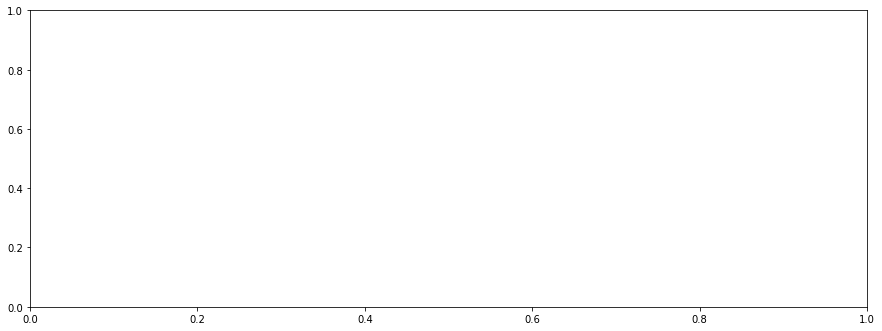

In [0]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,12))
plt.subplot(211)
plt.plot(t_loss)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('10 epoch')
plt.legend(['Train Loss'], loc='upper left')


plt.subplot(212)
plt.plot(v_loss)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.legend(['Val loss'], loc='upper left')
plt.show()

## Test Script

In [0]:
%cd /content/drive/My\ Drive/ece285-finalproject/pytorch-i3d

/content/drive/My Drive/ece285-finalproject/pytorch-i3d


In [0]:
# this file should be put in the pytorch-i3d directory

import os

import sys
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.utils.data as data_utl
from torch.utils.data.dataloader import default_collate

import torchvision
from torchvision import datasets, transforms
import videotransforms

from tqdm import tqdm

import numpy as np

from pytorch_i3d import InceptionI3d

In [14]:
# TODO: enter paths here
npy_path = 'data/drive_and_act_dataset/simmons_kinect_ir_train/'
test_list_path = npy_path + 'sample_test_list.txt'
model_path = '002370.pt'
CHANNELS = 3 # in_channels in InceptionI3D, 3 for RGB

# checking that paths are correct
print('npy dir exists: ' + str(os.path.exists(npy_path)))
print('test list exists: ' + str(os.path.exists(test_list_path)))
print('model exists: ' + str(os.path.exists(model_path)))

npy dir exists: True
test list exists: True
model exists: True


In [0]:

# Testing getting a tensor from one of our .npy files:
def video_to_tensor(pic):
    """Convert a ``numpy.ndarray`` to tensor.
    Converts a numpy.ndarray (T x H x W x C)
    to a torch.FloatTensor of shape (C x T x H x W)
    
    Args:
         pic (numpy.ndarray): Video to be converted to tensor.
    Returns:
         Tensor: Converted video.
    """
    return torch.from_numpy(pic.transpose([3,0,1,2]))


def make_our_dataset(train_list):
    dataset = []
    with open(train_list, 'r') as f: 
        Lines = f.readlines()
        print(len(Lines))
        for line in Lines: 
            contents = line.strip().split(" ")
            vid_path = contents[0]
            activity = contents[1]

            # get number of frames from name of vid_path
            start_str = ".mp4_"
            end_str = ".npy"
            num_frames = (vid_path.split(start_str))[1].split(end_str)[0]

            length = len(num_frames)
            start_frame = int(num_frames[0:int(length/2)])
            end_frame = int(num_frames[int(length/2):length])
            num_frames = end_frame - start_frame

            if int(num_frames) < 33: 
                continue

            dataset.append((vid_path, activity, num_frames))

    return dataset


class DriveAndAct(data_utl.Dataset):

    def __init__(self, train_list, mode, root, transforms=None):
        
        self.data = make_our_dataset(train_list)
        self.mode = mode # FLOW, RGB, gray
        self.root = root # root_dir that points to mode .npy files
        self.transforms = transforms # which transforms to perform 

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is class_index of the target class.
        """
        vid, label, nf = self.data[index]

        # imgs should be a .npy array with the correct dimensions
        if self.mode == 'rgb':
            imgs = np.load(self.root + self.data[index][0])
            imgs = imgs.astype(np.float32)
            imgs = (imgs/255.)*2-1 # normalization
            channels = 3
        elif self.mode == 'flow':
            # TO DO: change to flow dir
            print("TO DO: change to flow dir")
            # gray_path = "data/drive_and_act_dataset/simmons_kinect_ir_train/"
            # imgs = np.load(gray_path + self.data[index][0])
            channels = 2
        elif self.mode == 'gray': 
            imgs = np.load(self.root + self.data[index][0])
            imgs = imgs.astype(np.float32)
            imgs = (imgs/255.)*2-1 # normalization
            channels = 1
        else: 
            print("did not specify correct mode for data")
        
        label = self.data[index][1]

        num_frames = int(imgs.shape[0] / 224)
        imgs = imgs.reshape(int(num_frames), 224, 224, channels)

        imgs = np.repeat(imgs, 3, axis=3)

        label = int(label)
        labels = np.zeros((num_classes,num_frames), np.float32)
        labels[int(label),:] = 1
        
        return video_to_tensor(imgs), torch.from_numpy(labels)

    def __len__(self):
        return len(self.data)

In [0]:
def test(mode='rgb', batch_size=1, accuracy_per_frame = True):
    correct = 0
    total = 0
    
    # setting up dataloaders
    test_transforms = None
    val_dataset = DriveAndAct(test_list_path, mode=mode, root=npy_path, transforms=test_transforms)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

    dataloaders = {'val': val_dataloader}
    datasets = {'val': val_dataset}

    drive_num_classes = 39
    imagenet_num_classes = 400

    # set up model
    i3d = InceptionI3d(drive_num_classes, in_channels=CHANNELS)
    # Load in a pretrained dataset (RGB if in_channels=3, rgb_imagenet)
    # (Use flow when using our optical flow dataset)
    i3d.load_state_dict(torch.load(model_path))

    i3d.replace_logits(drive_num_classes)
    i3d.cuda()
    i3d = nn.DataParallel(i3d)

    y_pred = []
    y_true = []
    
    with torch.no_grad():  # Set model to evaluate mode

      counter = 0
      # Iterate over data.
      for data in tqdm(dataloaders['val']):

        if counter == 300: 
          break
        counter += 1

        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs = Variable(inputs.cuda())
        t = inputs.size(2)
        labels = Variable(labels.cuda())

        per_frame_logits = i3d(inputs)
        # upsample to input size
        per_frame_logits = F.upsample(per_frame_logits, t, mode='linear')
        
        # compute accuracy
        pred_values, pred_indices = per_frame_logits.max(1)
        actual_values, actual_indices = labels.max(1)
        pred_indices = pred_indices.squeeze()
        actual_indices = actual_indices.squeeze()
        # print statements to see what the predictions are
        #print(pred_indices[:], actual_indices[:])
        
        # calculates the accuracy for each frame in the npy
        if accuracy_per_frame:
          #print(" pred: ", pred_indices, " act: ", actual_indices)
          matches = torch.eq(pred_indices, actual_indices)
          #print("matches: ", matches)

          y_pred.extend(pred_indices.cpu().numpy())
          y_true.extend(actual_indices.cpu().numpy()) 

          correct += int(matches.sum())
          total += int(matches.shape[0])

        else:
            label = actual_indices[0]

            # get prediction counts across the all the frames in the segment
            pred_values, pred_counts = torch.unique(pred_indices, return_counts=True)
            # prediction is the action that was inferred the most times across the frames
            _, idx = pred_counts.max(0)
            pred = pred_values[idx]
            
            #print(type(pred_counts), pred_values, pred_counts)
            #print(pred, label)
            if pred == label:
                correct += 1
            total += 1
          
    return correct, total, y_pred, y_true
        
    #print('{} Loc Loss: {:.4f} Cls Loss: {:.4f} Tot Loss: {:.4f}'.format(phase, tot_loc_loss/num_iter, tot_cls_loss/num_iter, (tot_loss*num_steps_per_update)/num_iter))

In [101]:
correct, total, y_pred, y_true = test(mode='gray')

1203








  0%|          | 0/1038 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))






  0%|          | 1/1038 [00:00<04:16,  4.04it/s]





  0%|          | 2/1038 [00:00<04:22,  3.95it/s]





  0%|          | 3/1038 [00:00<03:51,  4.47it/s]





  0%|          | 4/1038 [00:00<03:29,  4.94it/s]





  0%|          | 5/1038 [00:00<03:16,  5.26it/s]





  1%|          | 6/1038 [00:01<03:06,  5.53it/s]





  1%|        

In [58]:
print(correct / total)

0.022836392979624774


In [59]:
print(y_true)
print(y_pred)

[33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,

In [68]:
# Create a confusion matrix: 
from sklearn.metrics import confusion_matrix
num_classes = 39
activities = ['sitting_still', 'standing_by_the_door', 'entering_car', 'closing_door_outside', 'closing_door_inside', 'opening_laptop', 'opening_door_inside', 'fetching_an_object', 'pressing_automation_button', 'fastening_seat_belt', 'using_multimedia_display', 'closing_laptop', 'placing_an_object', 'interacting_with_phone', 'drinking', 'opening_bottle', 'eating', 'preparing_food', 'looking_back_left_shoulder', 'reading_magazine', 'talking_on_phone', 'looking_or_moving_around (e.g. searching)', 'closing_bottle', 'putting_on_jacket', 'exiting_car', 'opening_door_outside', 'writing', 'working_on_laptop', 'putting_on_sunglasses', 'taking_off_sunglasses', 'opening_backpack', 'taking_laptop_from_backpack', 'reading_newspaper', 'taking_off_jacket', 'unfastening_seat_belt', 'putting_laptop_into_backpack', 'moving_towards_door', 'looking_back_right_shoulder', 'closing_backpack']
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 226    0    0 ...  926 1520  301]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...   51   12   28]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]


In [69]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(y_pred, y_true)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

TypeError: ignored

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=activities)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
#disp = disp.plot(include_values=include_values, cmap=cmap, ax=ax, xticks_rotation=xticks_rotation)

plt.show()

In [0]:

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [84]:
from sklearn.utils.multiclass import unique_labels
labels = activities
print(labels)
plot_confusion_matrix(np.array(y_true), np.array(y_pred), classes=None, normalize=False, title=None, cmap=plt.cm.Blues)

['sitting_still', 'standing_by_the_door', 'entering_car', 'closing_door_outside', 'closing_door_inside', 'opening_laptop', 'opening_door_inside', 'fetching_an_object', 'pressing_automation_button', 'fastening_seat_belt', 'using_multimedia_display', 'closing_laptop', 'placing_an_object', 'interacting_with_phone', 'drinking', 'opening_bottle', 'eating', 'preparing_food', 'looking_back_left_shoulder', 'reading_magazine', 'talking_on_phone', 'looking_or_moving_around (e.g. searching)', 'closing_bottle', 'putting_on_jacket', 'exiting_car', 'opening_door_outside', 'writing', 'working_on_laptop', 'putting_on_sunglasses', 'taking_off_sunglasses', 'opening_backpack', 'taking_laptop_from_backpack', 'reading_newspaper', 'taking_off_jacket', 'unfastening_seat_belt', 'putting_laptop_into_backpack']


TypeError: ignored

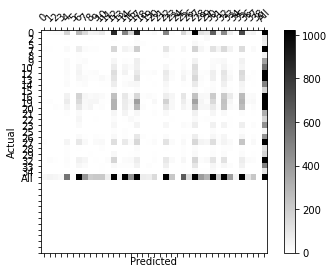

In [109]:
import matplotlib.pyplot as plt
import pandas as pd 

y_true_pd = pd.Series(y_true)
y_pred_pd = pd.Series(y_pred)

df_confusion = pd.crosstab(y_true_pd, y_pred_pd, rownames=['Actual'], colnames=['Predicted'], margins=True)

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
  plt.matshow(df_confusion, cmap=cmap) # imshow
  #plt.title(title)
  plt.clim(0, 1024) 
  plt.colorbar()
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=45)
  plt.yticks(tick_marks, df_confusion.index)
  #plt.tight_layout()
  plt.ylabel(df_confusion.index.name)
  plt.xlabel(df_confusion.columns.name)

  plt.show()

plot_confusion_matrix(df_confusion)

In [110]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_confusion)

Predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,All
Actual,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,15,20,19,170,0,277,150,47,54,84,10,864,14,499,161,895,12,14,26,1,488,15,0,163,47,1069,118,88,635,47,470,62,10,727,34,47,0,7353
2,0,0,0,0,7,0,3,0,6,0,1,0,8,0,1,0,21,0,0,0,0,0,1,0,0,0,13,0,21,0,4,4,0,0,0,0,0,0,90
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,19,8,0,0,0,2,0,0,0,0,32,8,0,0,0,0,0,0,0,0,0,0,74
7,8,5,3,0,22,0,72,18,8,12,0,0,165,0,49,28,201,4,0,7,0,106,13,0,35,3,179,36,11,119,46,151,51,7,144,1,22,0,1526
8,0,0,0,0,0,0,8,0,0,4,0,0,5,0,0,0,0,0,0,0,0,18,0,0,0,0,7,0,0,0,0,2,0,0,7,0,0,0,51
9,0,0,0,0,18,0,10,18,0,0,0,0,40,0,12,5,66,5,0,0,0,4,5,0,11,1,54,4,0,17,22,32,0,0,55,1,0,0,380
10,0,0,0,0,16,0,37,5,0,0,2,0,78,0,40,19,63,0,0,0,0,30,0,0,17,0,135,0,2,23,5,46,12,0,36,0,0,0,566
12,0,0,0,0,19,0,48,10,15,20,0,0,135,6,50,2,85,8,8,18,0,88,17,0,29,15,117,11,14,66,7,108,17,3,152,0,8,0,1076
13,0,0,0,1,14,0,35,22,12,8,26,12,109,4,11,11,125,0,6,0,0,71,13,0,46,7,159,19,7,63,0,90,28,0,128,8,5,0,1040
